# Нейросеть для распознованияч рускописных цифр (на основе MNIST)

In [1]:
import torch

In [2]:
import torch.nn as nn
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import torch.nn.functional as F

### Подготовка данных

In [50]:
trans = tv.transforms.Compose([tv.transforms.ToTensor()])

In [51]:
ds_mnist = tv.datasets.MNIST('./datasets', download=True, transform=trans)

In [52]:
batch_size = 16
dataloader = torch.utils.data.DataLoader(
    ds_mnist, batch_size=batch_size, shuffle=True,
    num_workers=1, drop_last=True
)

### Создание класса для модели

In [53]:

class Neural_numbers(nn.Module):
  def __init__(self):
    super().__init__()

    flat = nn.Flatten()
    linear1 = nn.Linear(28*28, 100)
    linear2 = nn.Linear(100, 10)

    act = nn.ReLU()

    self.model = nn.Sequential(flat, linear1, act, linear2)

  def forward(self, x):
    return self.model(x)

In [54]:
model = Neural_numbers()

In [55]:
loss_fn = nn.CrossEntropyLoss()

In [56]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [57]:
def accuracy(pred, label):
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  return answer.mean()

### Обучение модели

In [58]:
epochs = 3

for epoch in range(epochs):
  loss_val = 0
  acc_val = 0
  for img, label in (pbar := tqdm(dataloader)):
    optimizer.zero_grad()

    label = F.one_hot(label, 10).float()
    pred = model(img)

    loss = loss_fn(pred, label)
    loss_item = loss.item()
    loss_val += loss_item

    loss.backward()

    optimizer.step()

    acc_current = accuracy(pred, label)
    acc_val += acc_current
    pbar.set_description(f'loss: {loss_item:.4f}\t accuracy: {acc_current:.3f}')
  print(loss_val / len(dataloader))
  print(acc_val / len(dataloader))

  0%|          | 0/3750 [00:00<?, ?it/s]<ipython-input-57-0dbe26ece616>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.3315	 accuracy: 0.875: 100%|██████████| 3750/3750 [00:53<00:00, 70.69it/s]


0.6379576313048602
0.8437


loss: 0.1561	 accuracy: 0.938: 100%|██████████| 3750/3750 [00:48<00:00, 77.05it/s]


0.3109747587834795
0.9112833333333333


loss: 0.1201	 accuracy: 0.938: 100%|██████████| 3750/3750 [00:50<00:00, 74.54it/s]

0.26117401290585596
0.9258666666666666


Проверка работы обученной нейросети:

Result: 0
Image:


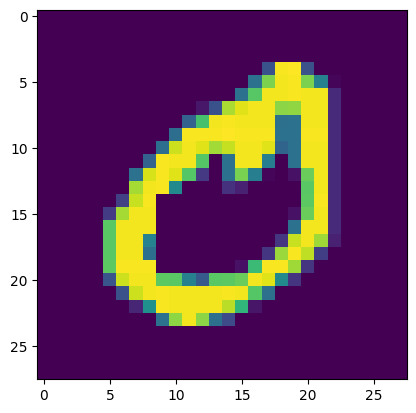

In [63]:
with torch.no_grad():
  y = model(ds_mnist[21][0])
print(f'Result: {y.argmax().item()}')
print('Image:')
plt.imshow(ds_mnist[21][0].numpy()[0])

### Трассировка и сохранение получившейся модели на TorchScript

In [64]:
sample = torch.randint(low=0, high=255, size=(1, 28, 28), dtype=torch.float32)
model_scr1 = torch.jit.trace(model, sample)
model_scr1.save('mnist.pth')

### Проверка работы сохраненной модели

In [66]:
model_scr = torch.jit.load('mnist.pth')

In [67]:
with torch.no_grad():
  y = model_scr(ds_mnist[21][0])
print(f'Result: {y.argmax().item()}')

Result: 0
